In [2]:
FN = 'ftrain'

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import time
import fconfig
import _pickle as pickle
import random
import sys
import argparse
import Levenshtein
# os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import TensorBoard

from keras.layers.core import Lambda
import keras.backend as K


In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--FN0', default='vocabulary-embedding', help="filename of vocab embeddings")
parser.add_argument('--FN1', default='train', help="filename of model weights")
parser.add_argument('--batch-size', type=int, default=32, help='input batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--maxlend', type=int, default=100, help='max length of description')
parser.add_argument('--maxlenh', type=int, default=15, help='max length of head')
parser.add_argument('--rnn-size', type=int, default=512, help='size of RNN layers')
parser.add_argument('--rnn-layers', type=int, default=3, help='number of RNN layers')
parser.add_argument('--nsamples', type=int, default=640, help='number of samples per epoch')
parser.add_argument('--nflips', type=int, default=0, help='number of flips')
parser.add_argument('--temperature', type=float, default=.8, help='RNN temperature')
parser.add_argument('--lr', type=float, default=0.0001, help='learning rate, default=0.0001')
args = parser.parse_known_args()[0]

In [4]:
maxlend = args.maxlend
maxlenh = args.maxlenh
maxlen = maxlend + maxlenh
rnn_size = args.rnn_size
rnn_layers = args.rnn_layers

In [5]:
start = time.time()
activation_rnn_size = 40 if maxlend else 0

# training parameters
seed = 42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
LR = args.lr
batch_size = args.batch_size

nb_train_samples = np.int(np.floor(args.nsamples / batch_size)) * batch_size
nb_val_samples = nb_train_samples


# read word embedding
with open(os.path.join(fconfig.path_data, '{}.pkl'.format(args.FN0)), 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

with open(os.path.join(fconfig.path_data, '{}.data.pkl'.format(args.FN0)), 'rb') as fp:
    X, Y = pickle.load(fp)

nb_unknown_words = 10

print('number of examples', len(X), len(Y))
print('dimension of embedding space for words: {:,}'.format(embedding_size))
print('vocabulary size: {:,} the last {:,} words can be used as place holders for unknown/oov words'.
      format(vocab_size, nb_unknown_words))
print('total number of different words: {:,}'.format(len(idx2word)))
print('number of words outside vocabulary which we can substitue using glove similarity: {:,}'.
      format(len(glove_idx2idx)))
print('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov): {:,}'.
      format(len(idx2word) - vocab_size - len(glove_idx2idx)))
print()

for i in range(nb_unknown_words):
    idx2word[vocab_size - 1 - i] = '<{}>'.format(i)

# when printing mark words outside vocabulary with `^` at their end
oov0 = vocab_size - nb_unknown_words

for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i] + '^'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)
del X
del Y

empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

def prt(label, x):
    print(label + ':',)
    print_str = ''
    for w in x:
        print_str += idx2word[w] + ' '
    print(print_str)
    print()

print('Random head, description:')
i = 811
prt('H', Y_train[i])
prt('D', X_train[i])


# Model

# seed weight initialization
random.seed(seed)
np.random.seed(seed)

regularizer = l2(weight_decay) if weight_decay else None


# start with a standaed stacked LSTM
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True,
                    name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True,
                W_regularizer=regularizer, U_regularizer=regularizer,
                b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                name='lstm_{}'.format(i + 1))
    model.add(lstm)
    model.add(Dropout(p_dense, name='dropout_{}'.format(i + 1)))


# A special layer that reduces the input just to its headline part (second half).
# For each word in this part it concatenate the output of the previous layer (RNN)
# with a weighted average of the outputs of the description part.
# In this only the last `rnn_size - activation_rnn_size` are used from each output.
# The first `activation_rnn_size` output is used to computer the weights for the averaging.

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:, :maxlend, :], X[:, maxlend:, :]
    head_activations, head_words = head[:, :, :n], head[:, :, n:]
    desc_activations, desc_words = desc[:, :, :n], desc[:, :, n:]

    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2, 2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20 * K.expand_dims(
        1. - K.cast(mask[:, :maxlend], 'float32'), 1)

    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies, (-1, maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights, (-1, maxlenh, maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2, 1))
    return K.concatenate((desc_avg_word, head_words))


class SimpleContext(Lambda):
    def __init__(self, **kwargs):
        super(SimpleContext, self).__init__(simple_context, **kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]

    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2 * (rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

if activation_rnn_size:
    model.add(SimpleContext(name='simplecontext_1'))

model.add(TimeDistributed(Dense(vocab_size,
                                W_regularizer=regularizer, b_regularizer=regularizer,
                                name='timedistributed_1')))
model.add(Activation('softmax', name='activation_1'))

# opt = Adam(lr=LR)  # keep calm and reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

K.set_value(model.optimizer.lr, np.float32(LR))

def str_shape(x):
    return 'x'.join(list(map(str, x.shape)))

def inspect_model(model):
    for i, l in enumerate(model.layers):
        print(i, 'cls={} name={}'.format(type(l).__name__, l.name))
        weights = l.get_weights()
        print_str = ''
        for weight in weights:
            print_str += str_shape(weight) + ' '
        print(print_str)
        print()

inspect_model(model)

# Load
FN1_filename = os.path.join(fconfig.path_models, '{}.hdf5'.format(args.FN1))
if args.FN1 and os.path.exists(FN1_filename):
    model.load_weights(FN1_filename)
    print('Model weights loaded from {}'.format(FN1_filename))

# Test
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty] * (maxlend - n) + x + [eos]

samples = [lpadd([3] * 26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

np.all(data[:, maxlend] == eos)
data.shape, list(map(len, samples))
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

# Sample generation

# this section is only used to generate examples. you can skip it if you just want to understand how the training works

# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty] * maxlend + [eos],
               k=1, maxsample=maxlen, use_unk=True, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n elements according to their energy"""
        n = min(n, len(energy))
        prb = np.exp(-np.array(energy) / temperature)
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb / z, 1))
            res.append(r)
            prb[r] = 0.  # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_k = 1  # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:, None] - np.log(probs)
        cand_scores[:, empty] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:, vocab_size - 1 - i] = 1e20
        live_scores = list(cand_scores.flatten())

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]

        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]

        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[1]
        live_samples = [live_samples[r // voc_size] + [r % voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]

        # add zombies to the dead
        dead_samples += [s for s, z in zip(live_samples, zombie) if z]
        dead_scores += [s for s, z in zip(live_scores, zombie) if z]
        # remove zombies from the living
        live_samples = [s for s, z in zip(live_samples, zombie) if not z]
        live_scores = [s for s, z in zip(live_scores, zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores

def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = list(map(len, samples))
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length - maxlend - 1]
                     for prob, sample_length in zip(probs, sample_lengths)])

def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x, x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x, vocab_size - 1 - min(i, nb_unknown_words - 1)) for i, x in enumerate(outside))
    xs = [outside.get(x, x) for x in xs]
    return xs

def vocab_unfold(desc, xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x, x) for x in xs]

def gensamples(skips=2, k=10, batch_size=batch_size, short=False, temperature=1., use_unk=True):
    i = random.randint(0, len(X_test) - 1)
    print('HEAD:', ' '.join(idx2word[w] for w in Y_test[i][:maxlenh]))
    print('DESC:', ' '.join(idx2word[w] for w in X_test[i][:maxlend]))
    sys.stdout.flush()

    print('HEADS:')
    x = X_test[i]
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend, len(x)), max(maxlend, len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s, start, scr) for s, scr in zip(sample, score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w // (256 * 256)) + chr((w // 256) % 256) + chr(w % 256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code, c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        else:
                print(score, ' '.join(words))
        codes.append(code)

gensamples(skips=2, batch_size=batch_size, k=10, temperature=args.temperature)


# Data generator

"""Data generator generates batches of inputs and outputs/labels for training. The inputs are each made from two parts. The first maxlend words are the original description, followed by `eos` followed by the headline which we want to predict, except for the last word in the headline which is always `eos` and then `empty` padding until `maxlen` words.
For each, input, the output is the headline words (without the start `eos` but with the ending `eos`) padded with `empty` words up to `maxlenh` words. The output is also expanded to be y-hot encoding of each word.
To be more realistic, the second part of the input should be the result of generation and not the original headline.
Instead we will flip just `nflips` words to be from the generator, but even this is too hard and instead
implement flipping in a naive way (which consumes less time.) Using the full input (description + eos + headline) generate predictions for outputs. For nflips random words from the output, replace the original word with the word with highest probability from the prediction.
"""

def flip_headline(x, nflips=None, model=None, debug=False):
    """given a vectorized input (after `pad_sequences`) flip some of the words in the second half (headline)
    with words predicted by the model
    """
    if nflips is None or model is None or nflips <= 0:
        return x

    batch_size = len(x)
    assert np.all(x[:, maxlend] == eos)
    probs = model.predict(x, verbose=0, batch_size=batch_size)
    x_out = x.copy()
    for b in range(batch_size):
        # pick locations we want to flip
        # 0...maxlend-1 are descriptions and should be fixed
        # maxlend is eos and should be fixed
        flips = sorted(random.sample(range(maxlend + 1, maxlen), nflips))
        if debug and b < debug:
            print(b)
        for input_idx in flips:
            if x[b, input_idx] == empty or x[b, input_idx] == eos:
                continue
            # convert from input location to label location
            # the output at maxlend (when input is eos) is feed as input at maxlend+1
            label_idx = input_idx - (maxlend + 1)
            prob = probs[b, label_idx]
            w = prob.argmax()
            if w == empty:  # replace accidental empty with oov
                w = oov0
            if debug and b < debug:
                print('{} => {}'.format(idx2word[x_out[b, input_idx]], idx2word[w]),)
            x_out[b, input_idx] = w
        if debug and b < debug:
            print()
    return x_out

def conv_seq_labels(xds, xhs, nflips=None, model=None, debug=False):
    """description and hedlines are converted to padded input vectors. headlines are one-hot to label"""
    batch_size = len(xhs)
    assert len(xds) == batch_size
    x = [vocab_fold(lpadd(xd) + xh) for xd, xh in zip(xds, xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value=empty, padding='post', truncating='post')
    x = flip_headline(x, nflips=nflips, model=model, debug=debug)

    y = np.zeros((batch_size, maxlenh, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh) + [eos] + [empty] * maxlenh  # output does have a eos at end
        xh = xh[:maxlenh]
        y[i, :, :] = np_utils.to_categorical(xh, vocab_size)

    return x, y

def gen(Xd, Xh, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, seed=seed):
    """yield batches. for training use nb_batches=None
    for validation generate deterministic results repeating every nb_batches
    while training it is good idea to flip once in a while the values of the headlines from the
    value taken from Xh to value generated by the model.
    """
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, 2e10)
        random.seed(c + 123456789 + seed)
        for b in range(batch_size):
            t = random.randint(0, len(Xd) - 1)

            xd = Xd[t]
            s = random.randint(min(maxlend, len(xd)), max(maxlend, len(xd)))
            xds.append(xd[:s])

            xh = Xh[t]
            s = random.randint(min(maxlenh, len(xh)), max(maxlenh, len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c += 1
        random.seed(new_seed)

        yield conv_seq_labels(xds, xhs, nflips=nflips, model=model, debug=debug)

def test_gen(gen, n=5):
    Xtr, Ytr = next(gen)
    for i in range(n):
        assert Xtr[i, maxlend] == eos
        x = Xtr[i, :maxlend]
        y = Xtr[i, maxlend:]
        yy = Ytr[i, :]
        yy = np.where(yy)[1]
        prt('L', yy)
        prt('H', y)
        if maxlend:
            prt('D', x)

r = next(gen(X_train, Y_train, batch_size=batch_size))
valgen = gen(X_test, Y_test, nb_batches=3, batch_size=batch_size)

# Train
history = {}
traingen = gen(X_train, Y_train, batch_size=batch_size, nflips=args.nflips, model=model)
valgen = gen(X_test, Y_test, nb_batches=nb_val_samples // batch_size, batch_size=batch_size)

callbacks = [TensorBoard(
    log_dir=os.path.join(fconfig.path_logs, str(time.time())),
    histogram_freq=2, write_graph=False, write_images=False)]

h = model.fit_generator(
    traingen, samples_per_epoch=nb_train_samples,
    nb_epoch=args.epochs, validation_data=valgen, nb_val_samples=nb_val_samples,
    callbacks=callbacks,
)
for k, v in h.history.items():
    history[k] = history.get(k, []) + v
with open(os.path.join(fconfig.path_models, 'history.pkl'.format(
)), 'wb') as fp:
    pickle.dump(history, fp, -1)
model.save_weights(FN1_filename, overwrite=True)
gensamples(skips=2, batch_size=batch_size, k=10, temperature=args.temperature)

end = time.time()
print("Time passed is %s"%(end - start))

number of examples 10000 10000
dimension of embedding space for words: 100
vocabulary size: 40,000 the last 10 words can be used as place holders for unknown/oov words
total number of different words: 138,281
number of words outside vocabulary which we can substitue using glove similarity: 33,731
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov): 64,550

Random head, description:
H:
captured 

D:
at scrapbooking^ top 50 aus , we have a fun tic tac^ toe challenge for you all this month ! ! all you need to do is select any row of items - horizontal , vertical or diagonal^ - and then use the 3 items / techniques on your layout ! our awesome sponsor this month is michelle at scrapbook divas ! ! michelle is offering a $ 20 voucher to our lucky winner ! here is my page i have used leaves , washi^ tape , strip journaling hope you can play along ! 

0 cls=Embedding name=embedding_1
40000x100 

1 cls=LSTM name=lstm_1
100x512 512x512 512 100x512 512x512 512 100x512 512

In [6]:
gensamples(skips=2, batch_size=batch_size, k=10, temperature=args.temperature)

HEAD: man dies after car collides^ with tree and lamppost^ in dudley
DESC: a man has died after the car he was driving collided with a tree and lamppost^ in dudley last night ( september 29 ) . west midlands ambulance service was called to reports of a single car which had left the road at the junction of the birmingham new road and priory^ road at 10.20pm^ yesterday . a paramedic area support officer and two ambulance crews attended the scene , but despite their best efforts the man went into cardiac arrest and was confirmed dead a short time later . a west midlands ambulance service spokeswoman said : “ when
HEADS:
2.57538557053 
2.57542085648 
6.42714238167 :
7.04125666618 for
11.4461870193 : &apos;
11.8024477959 , on
11.865852356 the with
13.7911877632 the red
15.0560615063 : and to
15.7778766155 the with to
16.0015654564 the with the
23.4199593067 : and , 10.20pm^ 10.20pm^
48.0664536953 : and , 10.20pm^ 10.20pm^ % ’ to 10.20pm^ of
48.8467357159 the with to of to to to to to and of

In [9]:
#this part is taken from the predict.ipynb due to issues i had in rebuilding the model and loading the weights

with open(os.path.join('data/', 'vocabulary-embedding.data.pkl'), 'rb') as fp:
    X_data, Y_data = pickle.load(fp)

In [10]:
i = np.random.randint(len(X_data))
sample_str = ''
sample_title = ''
for w in X_data[i]:
    sample_str += idx2word[w] + ' '
for w in Y_data[i]:
    sample_title += idx2word[w] + ' '
print(sample_title)
print(sample_str)
sample_title = Y_data[i]

u.s . , china make progress ; differences lurk 
president barack obama said friday that china and the united states had agreed to work to avoid military misunderstandings^ and desist from cybertheft^ for commercial gain during a state visit with chinese president xi jinping . first lady michelle obama and china &apos;s first lady peng liyuan^ announced friday that the panda born last month in washington , d.c . , has been named &quot; bei bei , &quot; which means &quot; precious treasure , &quot; according to the smithsonian &apos;s national zoo . chinese president xi jinping has faced a barrage of criticism from u.s. presidential hopefuls recently , but american and other foreign students living in china think he &apos;s a handsome , wise and humble leader , who &apos;s strong on foreign policy . at least th ... during his second day in seattle , chinese president xi jinping met wednesday with some of the biggest names in tech and then toured a boeing airplane factory . the aerospace 

In [25]:
def pred_gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print('HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i]))
        print('DESC:',' '.join(idx2word[w] for w in X_test[i]))
        sys.stdout.flush()
        x = X_test[i]
    else:
        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indeicies
        if isinstance(avoid,str) or isinstance(avoid[0], int):
            avoid  [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [[a] for a in avoid]

    print('HEADS:')
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    print(skips)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = pred_beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    s' '.join(idx2word[w] for w in headline)amples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print(score, ' '.join(words))
        else:
                print(score, ' '.join(words))
        codes.append(code)
    return samples

In [26]:
def pred_beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [27]:
samples = pred_gensamples(sample_str, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
range(100, 1517, 709)
2.57550764084 
14.8342759609 to in :


In [29]:
headline = samples[0][0][len(samples[0][1]):]

In [30]:
' '.join(idx2word[w] for w in headline)

'~'

In [31]:
avoid = headline

In [33]:
samples = pred_gensamples(sample_str, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
range(100, 1517, 709)
2.67538437843 
6.48762273788 to


In [35]:
avoid = samples[0][0][len(samples[0][1]):]

In [37]:
samples = pred_gensamples(sample_str, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

HEADS:
range(100, 1517, 709)
2.67538437843 
13.3829202652 it cybertheft^
19.4339079857 : : &apos; the


In [38]:
len(samples)

20

# <font color=black>WEIGHTS</font>

In [315]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    #assert mask.get_shape().ndim == 2
    #activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [146]:
wmodel = Sequential()
wmodel.add(model)

In [324]:
#wmodel.add(SimpleContext())
#inspect_model(model)
tmodel = Sequential()
#inspect_model(tmodel)
tmodel.add(model.get_layer('embedding_1'))
tmodel.add(model.get_layer('lstm_1'))
tmodel.add(model.get_layer('dropout_1'))
tmodel.add(model.get_layer('lstm_2'))
tmodel.add(model.get_layer('dropout_2'))
tmodel.add(model.get_layer('lstm_3'))
tmodel.add(model.get_layer('dropout_3'))
#tmodel.add(model.get_layer('simplecontext_1'))
#wmodel.add(WSimpleContext())
#wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)
#inspect_model(tmodel)

In [317]:
#tmodel.add(model.get_layer('simplecontext_1'))
tmodel.add(WSimpleContext())
#tmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)


In [325]:
tmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [319]:
inspect_model(tmodel)

0 cls=Embedding name=embedding_1
40000x100 

1 cls=LSTM name=lstm_1
100x512 512x512 512 100x512 512x512 512 100x512 512x512 512 100x512 512x512 512 

2 cls=Dropout name=dropout_1


3 cls=LSTM name=lstm_2
512x512 512x512 512 512x512 512x512 512 512x512 512x512 512 512x512 512x512 512 

4 cls=Dropout name=dropout_2


5 cls=LSTM name=lstm_3
512x512 512x512 512 512x512 512x512 512 512x512 512x512 512 512x512 512x512 512 

6 cls=Dropout name=dropout_3


7 cls=WSimpleContext name=wsimplecontext_27




# <font color=black>Test</font>

In [45]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [59]:
context_weight = K.variable(1.)
head_weight = K.variable(1.)
cross_weight = K.variable(0.)

In [62]:
#because it runs on tensorflow backend, the set_value function is under backend and not under variable
K.set_value(context_weight,np.float32(1.))
K.set_value(head_weight,np.float32(1.))

In [63]:
sample = samples[0][0]

In [64]:
' '.join([idx2word[w] for w in sample])

'president barack obama said friday that china and the united states had agreed to work to avoid military misunderstanding and desist from <0>^ for commercial gain during a state visit with chinese president xi jinping . first lady michelle obama and china &apos;s first lady peng kalra announced friday that the panda born last month in washington , d.c . , has been named &quot; bei bei , &quot; which means &quot; precious treasure , &quot; according to the smithsonian &apos;s national zoo . chinese president xi jinping has faced a barrage of criticism from u.s. presidential hopefuls recently , ~ ~'

In [256]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

(1, 115)

In [322]:
print(data[0])

[  187  3635  1005    38   266    14   350     5     2   254   279    68
  1906     6   153     6  1461  1065 24033     5 27551    31 39999    10
   873  1762   162     8   129   181    16  1141   187  2869  6903     4
    73  2742  4327  1005     5   350    23    73  2742 28625 38491   352
   266    14     2 14169  1767   105   351     9   642     3  5381     4
     3    37    63  1066    12 17986 17986     3    12    60   715    12
  3863  7909     3    12   240     6     2 29780    23   211  4952     4
  1141   187  2869  6903    37  2834     8 24455     7  3473    31   579
  1347 15086   673     3     1     1     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [326]:
tmodel.predict(data, verbose=0, batch_size=1)
tweights.shape

(1, 115, 512)

In [113]:
startd = np.where(data[0,:] != empty)[0][0]
lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
print(startd, lenh)
print(data[0,maxlend+1:])
print(np.where(data[0,maxlend+1:] == eos)[0])

lenh=2

0 0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0]


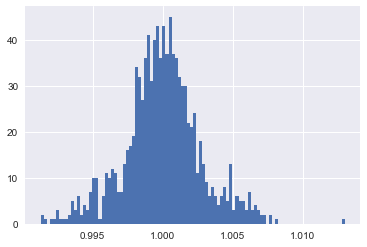

In [327]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);
plt.hist(np.array(tweights[0,:lenh,startd:].flatten()+1), bins=100);

In [69]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [116]:
heat(sample, weights[0,-1])

In [328]:
heat(sample, tweights[0,-1])

In [117]:
import pandas as pd
import seaborn as sns

In [118]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

In [330]:
#df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)
print((weights[0,:lenh,startd:]))
print(len(columns))
df = pd.DataFrame(tweights[0,:lenh,startd:],columns=columns,index=rows)


[[  6.99473048e-07   7.61245564e-02   1.59919281e-02 ...,   5.55709528e-04
    2.86300131e-03   1.64231844e-02]
 [  6.99473333e-07   7.61244446e-02   1.59919094e-02 ...,   5.55710052e-04
    2.86300667e-03   1.64232161e-02]]
100


ValueError: Shape of passed values is (512, 2), indices imply (100, 2)